In [197]:
library(bnlearn)
library(Rgraphviz)
#library(parallel)
library(tidyverse)
suppressWarnings(library(dplyr))
#library(bnlearn) |> suppressPackageStartupMessages()
#library(Rgraphviz) |> suppressPackageStartupMessages()
#library(parallel) |> suppressPackageStartupMessages()
#library(tidyverse) |> suppressPackageStartupMessages()
#library(dplyr) |> suppressPackageStartupMessages()
library(igraph) |> suppressPackageStartupMessages()
#library(bnstruct) |> suppressPackageStartupMessages()

### dataset needs to be preprocessed because  for example had values as factors. My functions does not work w/factorslearning.test

Today i learnt that the k2 algorithm infers the dag, the directed acyclic graph, so the structure of the bayesian network from the dataset. Not from the fitted model. 
What i initially thought was that you happen to have a model and you want to reverse engineer that. 

In [198]:
factor_remover <- function(dataset) {
    cols <- colnames(dataset)
    for (i in seq_along(cols)) {
        name <- cols[i]
        dataset[[name]] <- as.character(dataset[[name]])
    }
    return(dataset)
}


In [199]:


node.values <- function(dataset, parents) {
    # retrieves the unique values of the nodes
    #return a list of vectors, 
    # each vector contains the unique values of the corresponding node
    output <- list()
    for (kk in seq_along(parents)) {
        node <- parents[kk]
        node.vals <- unique(dataset[[node]]) #it was levels()
        output[[kk]] <- node.vals
    }
    return(output)
}


In [200]:

fastalphaijk <- function(i, pii, dataset, nodes.order, smooth=FALSE) {
    actual_node <- nodes.order[i]
    all.nodes <- c(pii, actual_node)
    subset <- dataset[all.nodes]
    unique.instantiations <- expand.grid(node.values(dataset, all.nodes))
    colnames(unique.instantiations) <- colnames(subset)
    subset.counted <- subset |> group_by(across(everything())) |> summarise(n = n(), .groups="drop")
    checking <-  left_join(unique.instantiations, subset.counted, by=colnames(subset), na_matches="na")  |> arrange(across(-last_col()))
    checking$n[is.na(checking$n)]<- 0
    if (smooth) {
        checking$n <- checking$n + 1   # SOFIA's laplace smoothing
    } else {}
    #cat("\n")
    #print(checking)
    #cat( "\n \n")
    return(checking$n)
}

In [201]:

k2helper <- function(i, pii, dataset, nodes.order, log=TRUE) {
    # the "f" function in the pdf
    #cat("\n------------------\n")
    phi_i <- expand.grid(node.values(dataset, pii)) 
    #cat("\nphi.i")
    #print( phi_i)
    q_i <- dim(phi_i)[1] # works good
    #cat("\nqi.i", q_i)
    i.th.node <- nodes.order[i]
    #cat("\nithnode", i.th.node)
    v_i <- node.values(dataset, i.th.node)
    #cat("\nvi")
    #print(v_i)
    r_i <- length(v_i[[1]])
    #cat("\nri", r_i)
    individual_alphas <- fastalphaijk(i, pii, dataset, nodes.order) # works good
    #cat("\nindividual alphas::",individual_alphas)
    aijk <- prod(factorial(individual_alphas)) ##
    grouping_alphas <- matrix(individual_alphas, nrow=r_i) # to get the right Nijs
    nij <- colSums(grouping_alphas)
    #print(nij)
    
    produttoria_alpha <- prod(factorial(individual_alphas))
    log_produttoria_alpha <- sum(lgamma(individual_alphas + 1))
    log_numeratore <- lgamma(r_i) # r_i - 1 + 1 = r_i
    numeratore <- factorial(r_i-1)
    log_denominatore <- lgamma(nij + r_i) # nij + r_i - 1 + 1 = nij + r_i
    denominatore <- factorial(nij+r_i-1)
    log_out <- log_numeratore - log_denominatore + log_produttoria_alpha
    out1 <- prod((numeratore/denominatore))*produttoria_alpha
    out2 <- sum(log_out)
    #cat("logout", log_out)
    ifelse(log, out <- out2, out<- out1)
    #cat("\nproduttoria_alpha",produttoria_alpha )
    #cat("\nproduttoria_alpha",produttoria_alpha )
    #print(frazione)
    return(out)
}



In [202]:

k2 <- function(dataset, nodes.order, upperbound) {
    start <- Sys.time()  # SOFIA
    edges <- list()  # ← new: store edges here  SOFIA
    nodes <- colnames(dataset)
    for (i in seq_along(nodes.order)) {
        actual_node <- nodes.order[i]
        #cat("\n", i,"\n")
        pii <- c()
        p.old <- k2helper(i, pii,dataset, nodes.order)
        #cat("\n ",p.old, "\n should be ", 1/2772)
        proceed <- TRUE
        #cat("\ni::",i, "\n")
        while (proceed && length(pii) < upperbound) {
            predecessors_idx <- i-1
            predecessors <- nodes.order[0:predecessors_idx]
            #cat("\npredecessors::", predecessors, " pii:: ", pii)
            piiuz <- setdiff(predecessors, pii)
            if (length(piiuz) > 1) {
                daddy.s.probs <- c()
                for (daddy in seq_along(piiuz)) {
                    p.new <- k2helper(i, piiuz[daddy], dataset, nodes.order)
                    daddy.s.probs <- c(daddy.s.probs, c(p.new))
                }
                p.new <- max(daddy.s.probs)
                #cat("pnew", p.new, "pold", p.old)
                genitore <-  piiuz[daddy.s.probs == p.new]
            } else {
                p.new <- k2helper(i, piiuz, dataset, nodes.order)
                genitore <- piiuz
            }
            #cat("\npiiuz:: ",piiuz,"\np.old:: ", p.old, "\np.new:: ", p.new)    #edge_matrix <- do.call(rbind, edges)

            #roof <- roof+1
            if (p.new > p.old) {
                p.old <- p.new
                pii <- c(pii, genitore)
                #ifelse(roof>length(nodes)^length(nodes), proceed <- FALSE, proceed <- TRUE)
            } else  {
                proceed <- FALSE
            }
        }
        #cat('\nNode', nodes.order[i], '--> Parents:', pii,'\n') 
        
        # Store edges: each pii is a parent of actual_node  SOFIA
        if (length(pii) > 0) {
            for (parent in pii) {
                edges[[length(edges) + 1]] <- c(parent, actual_node, p.new)
            }
        }
    }
    end <- Sys.time()
    execution_time <- difftime(time1 = end, time2 = start, units = "secs") 
    cat("\nExecution Time:", execution_time, "s")

    # Convert to matrix or return edge list
    edge_matrix <- do.call(rbind, edges)
    return(edge_matrix)
}


In [203]:
###Trial with Paper dataset
#
#df <- data.frame(x1=c(1,1,0,1,0,0,1,0,1,0), x2=c(0,1,0,1,0,1,1,0,1,0), x3=c(0,1,1,1,0,1,1,0,1,0))
#k2(dataset=df, upperbound=2, nodes.order=colnames(df))


In [204]:

## Trial w/ learning.test
df <- learning.test
#print(sapply(df, class))
df <- factor_remover(df)
#print(sapply(df, class))

In [ ]:
exploscorer <- function(dataset) {
    
    permutations <- 
}

[1] 720   6

In [211]:
class(df)

[1] "data.frame"

In [205]:
edges <- k2(dataset=df, upperbound = 2, nodes.order = sample(colnames(df)))
edges


Execution Time: 0.7749052 s

B,A,-5500.68559666216
B,C,53756.6031284125
C,D,51207.9254108185
C,F,55155.9164153011
C,E,51079.9098403087


In [206]:
# Convert to graph
g <- graph_from_edgelist(edges[1:2,], directed = T)



# Plot it
plot(g,
     vertex.color = "white",
     vertex.size = 30,
     edge.arrow.size = 0.5,
     layout = layout_as_tree,
     main = "Bayesian Network")

ERROR: Error in graph_from_edgelist(edges[1:2, ], directed = T): graph_from_edgelist expects a matrix with two columns


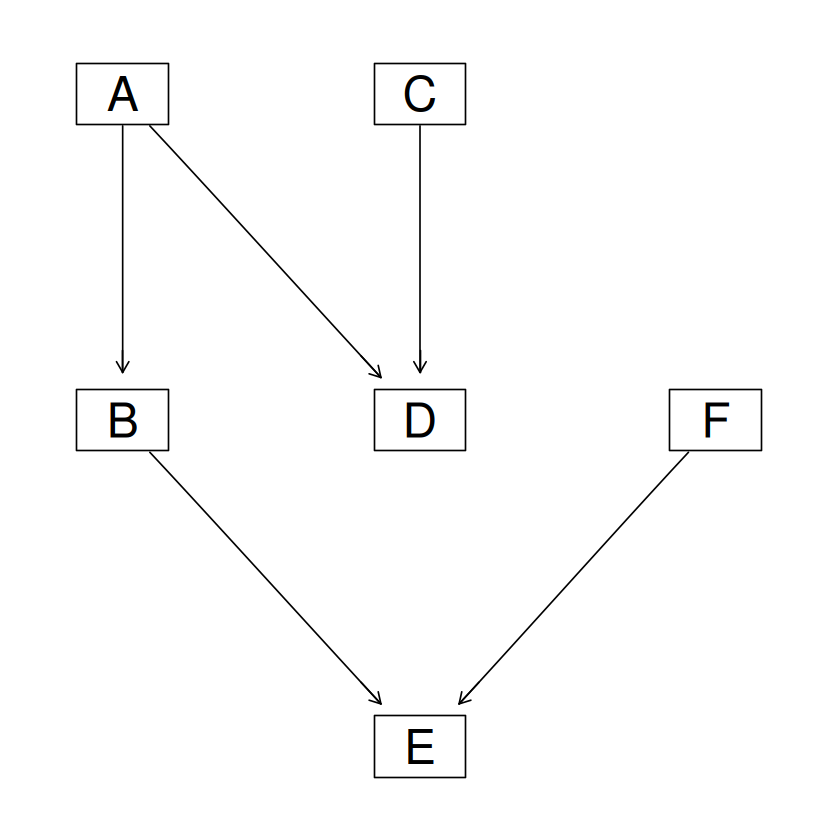

In [ ]:
dag = model2network("[A][C][F][B|A][D|A:C][E|B:F]")
graphviz.plot(dag)

In [ ]:
?learning.test

learning.test             package:bnlearn              R Documentation

_S_y_n_t_h_e_t_i_c (_d_i_s_c_r_e_t_e) _d_a_t_a _s_e_t _t_o _t_e_s_t _l_e_a_r_n_i_n_g _a_l_g_o_r_i_t_h_m_s

_D_e_s_c_r_i_p_t_i_o_n:

     This a synthetic data set used as a test case in the ‘bnlearn’
     package.

_U_s_a_g_e:

     data(learning.test)
     
_F_o_r_m_a_t:

     The ‘learning.test’ data set contains the following variables:

        • ‘A’, a three-level factor with levels ‘a’, ‘b’ and ‘c’.

        • ‘B’, a three-level factor with levels ‘a’, ‘b’ and ‘c’.

        • ‘C’, a three-level factor with levels ‘a’, ‘b’ and ‘c’.

        • ‘D’, a three-level factor with levels ‘a’, ‘b’ and ‘c’.

        • ‘E’, a three-level factor with levels ‘a’, ‘b’ and ‘c’.

        • ‘F’, a two-level factor with levels ‘a’ and ‘b’.

_N_o_t_e:

     The R script to generate data from this network is available from
     <https://www.bnlearn.com/docu